# 🔥 Diffusion Models

In this notebook, we'll walk through the steps required to train your own diffusion model on the Oxford flowers dataset

The code is adapted from the excellent ['Denoising Diffusion Implicit Models' tutorial](https://keras.io/examples/generative/ddim/) created by András Béres available on the Keras website.

In [18]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8-colorblind")

import math

import tensorflow as tf
from tensorflow.keras import (
    layers,
    models,
    optimizers,
    utils,
    callbacks,
    metrics,
    losses,
    activations,
)

%cd /home/clachris/Documents/projects/Generative_Deep_Learning_2nd_Edition/notebooks

from utils import display, sample_batch

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/home/clachris/Documents/projects/Generative_Deep_Learning_2nd_Edition/notebooks


## 0. Parameters <a name="parameters"></a>

In [19]:
IMAGE_SIZE = 64
BATCH_SIZE = 64
DATASET_REPETITIONS = 5
LOAD_MODEL = False

NOISE_EMBEDDING_SIZE = 32
PLOT_DIFFUSION_STEPS = 20

# optimization
EMA = 0.999
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-4
EPOCHS = 50

## 1. Prepare the Data

In [20]:
# Load the data
train_data = utils.image_dataset_from_directory(
    "/home/clachris/Documents/projects/Generative_Deep_Learning_2nd_Edition/data/flowers/dataset",
    labels=None,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=None,
    shuffle=True,
    seed=42,
    interpolation="bilinear",
)

Found 8189 files belonging to 1 classes.


In [21]:
# Preprocess the data
def preprocess(img):
    img = tf.cast(img, "float32") / 255.0
    return img


train = train_data.map(lambda x: preprocess(x))
train = train.repeat(DATASET_REPETITIONS)
train = train.batch(BATCH_SIZE, drop_remainder=True)

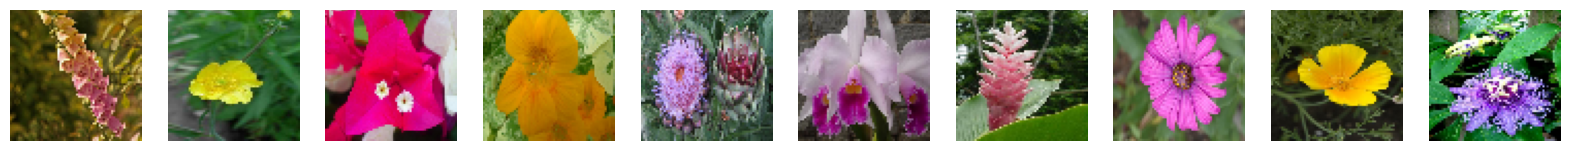

In [22]:
# Show some items of clothing from the training set
train_sample = sample_batch(train)
display(train_sample)

### 1.1 Diffusion schedules <a name="diffusion_schedules"></a>

In [23]:
def linear_diffusion_schedule(diffusion_times):
    min_rate = 0.0001
    max_rate = 0.02
    betas = min_rate + diffusion_times * (max_rate - min_rate)
    alphas = 1 - betas
    alpha_bars = tf.math.cumprod(alphas)
    signal_rates = tf.sqrt(alpha_bars)
    noise_rates = tf.sqrt(1 - alpha_bars)
    return noise_rates, signal_rates

In [24]:
def cosine_diffusion_schedule(diffusion_times):
    signal_rates = tf.cos(diffusion_times * math.pi / 2)
    noise_rates = tf.sin(diffusion_times * math.pi / 2)
    return noise_rates, signal_rates

In [25]:
def offset_cosine_diffusion_schedule(diffusion_times):
    min_signal_rate = 0.02
    max_signal_rate = 0.95
    start_angle = tf.acos(max_signal_rate)
    end_angle = tf.acos(min_signal_rate)

    diffusion_angles = start_angle + diffusion_times * (end_angle - start_angle)

    signal_rates = tf.cos(diffusion_angles)
    noise_rates = tf.sin(diffusion_angles)

    return noise_rates, signal_rates

In [26]:
T = 1000
diffusion_times = tf.convert_to_tensor([x / T for x in range(T)])
linear_noise_rates, linear_signal_rates = linear_diffusion_schedule(
    diffusion_times
)
cosine_noise_rates, cosine_signal_rates = cosine_diffusion_schedule(
    diffusion_times
)
(
    offset_cosine_noise_rates,
    offset_cosine_signal_rates,
) = offset_cosine_diffusion_schedule(diffusion_times)

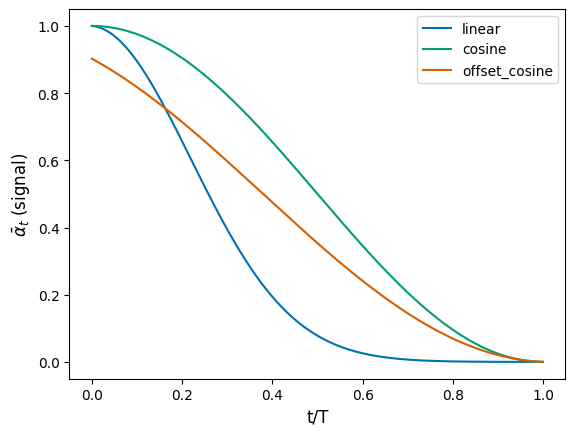

In [27]:
plt.plot(
    diffusion_times, linear_signal_rates**2, linewidth=1.5, label="linear"
)
plt.plot(
    diffusion_times, cosine_signal_rates**2, linewidth=1.5, label="cosine"
)
plt.plot(
    diffusion_times,
    offset_cosine_signal_rates**2,
    linewidth=1.5,
    label="offset_cosine",
)

plt.xlabel("t/T", fontsize=12)
plt.ylabel(r"$\bar{\alpha}_t$ (signal)", fontsize=12)
plt.legend()
plt.show()

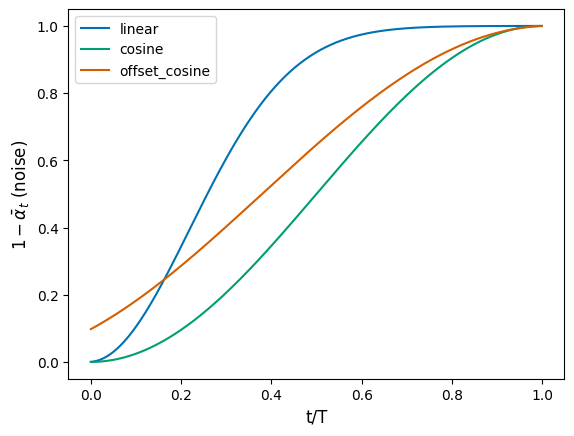

In [28]:
plt.plot(
    diffusion_times, linear_noise_rates**2, linewidth=1.5, label="linear"
)
plt.plot(
    diffusion_times, cosine_noise_rates**2, linewidth=1.5, label="cosine"
)
plt.plot(
    diffusion_times,
    offset_cosine_noise_rates**2,
    linewidth=1.5,
    label="offset_cosine",
)

plt.xlabel("t/T", fontsize=12)
plt.ylabel(r"$1-\bar{\alpha}_t$ (noise)", fontsize=12)
plt.legend()
plt.show()

## 2. Build the model <a name="build"></a>

## Mathematical Overview

### Model Basics

In a *Denoising Diffusion Model* (DDM), the idea is to introduce noise of a form we understand well (Gaussian) to an image and have the model remove the noise. As it gets better at doing so, when we give it a completely random, noisy image, it will remove the noise step-by-step until we have an image that could have come from the dataset. As in, $\mathbf{x}_0 \sim q(\mathbf{x}_0)$ and $\mathbf{x}_T \sim \mathcal{N}(0,\mathbf{I})$

The *Forward Process* is where the image is noised. Beginning with some initial image $\mathbf{x}_0 \sim q(\mathbf{x}_0)$, we add noise of the form:

$$ \mathbf{x}_t = \sqrt{1-\beta_t}\mathbf{x}_{t-1} + \sqrt{\beta_t} \epsilon_{t-1} $$

Another way to write this is:

$$ q(\mathbf{x}_t|\mathbf{x}_{t-1}) = \mathcal{N}(\mathbf{x}_t; \sqrt{1-\beta_t}\mathbf{x}_{t-1}, \sqrt{\beta_t} \mathbf{I}) $$ 

Since each step is independent of any other but the previous, we can write the entire chain as:

$$ q(\mathbf{x}_{1:T}|\mathbf{x}_0) = \Pi_{t=1}^T q(\mathbf{x}_t|\mathbf{x}_{t-1}) \approx \mathcal{N}(0, \mathbf{I}) $$

However, we can actually sample at any given timepoint, avoiding having to go through the entire chain, by the following:

$$ \alpha_t = 1-\beta_t,  \bar{\alpha}_t = \Pi_{s=1}^t \alpha_s $$

From this, we get:

$$ \mathbf{x}_t = \sqrt{\bar{\alpha}_t}\mathbf{x}_0 + \sqrt{1-\bar{\alpha}_t} \epsilon $$

$$ q(\mathbf{x}_t|\mathbf{x}_{t-1}) = \mathcal{N}(\mathbf{x}_t; \sqrt{\bar{\alpha}_t}\mathbf{x}_0, \sqrt{1-\bar{\alpha}_t} \mathbf{I}) $$ 

Now, we will train a neural network to estimate the probability density function of the *previous* time step. This looks like:

$$ p_{\theta}(\mathbf{x}_{t-1}|\mathbf{x}_t) = \mathcal{N}(\mathbf{x}_{t-1}; \mu_{\theta}(\mathbf{x}, t), \Sigma_{\theta}(\mathbf{x}_t, t)) $$

For the same reasons as above, we can write the entire chain as:

$$ p_{\theta}(\mathbf{x}_{0:T}) := p(\mathbf{x}_T) \Pi_{t=1}^T p_{\theta}(\mathbf{x}_{t-1}|\mathbf{x}_t) $$

Recall that $p(\mathbf{x}_T)$ is the final image after lots of noising, so we expect $p(\mathbf{x}_T) \approx \mathcal{N}(0,\mathbf{I})$, hence the absence of the $\theta$ subscript.

Then, the actual original image is:

$$ p_{\theta}(\mathbf{x}_0) := \int p_{\theta}(\mathbf{x}_{0:T}) d\mathbf{x}_{1:T} $$

As in, we need to sum over all possible paths we could take (theoretically).

### Noise Scheduling

We see in the above the *Linear Diffusion Scheduler*, the *Cosine Diffusion Scheduler*, and the *Offset Cosine Diffusion Scheduler*, which control how noise is added to the image. 

They take in the number of timesteps, $T$, and output all the $\bar{\alpha}_t$ and $\sqrt{1-\bar{\alpha}_t}$

The linear is essentially what it sounds like. The Cosine Diffusion Scheduler defines $\bar{\alpha}_t = \cos^2(\frac{t}{T} \frac{\pi}{2})$. The update equation is then: 

$$ \mathbf{x}_t = \cos \left( \frac{t}{T} \frac{\pi}{2} \right) \mathbf{x}_0 + \sin \left( \frac{t}{T} \frac{\pi}{2} \right) \epsilon $$

Meanwhile, the Offset Cosine Diffusion Scheduler just ensures that the beginning steps aren't too small.

Note that we define $\bar{\alpha}_t$ as the signal rate and $\sqrt{1-\bar{\alpha}_t}$ is the noise rate, as we apply it to the noise.

### Training

Now, we are going to derive the loss function. We begin with the usual loss function:

$$ \mathcal{L} = \mathbb{E}[- \log(p_{\theta}(\mathbf{x}_0))] $$

We can then bound this with:

$$ \mathbb{E}[- \log(p_{\theta}(\mathbf{x}_0))] \leq \mathbb{E}_q \left[ -\log \left( \frac{p_{\theta}(\mathbf{x}_{0:T})}{q(\mathbf{x}_{1:T}|\mathbf{x}_t)} \right) \right] $$

We can further bound it by:

$$ \leq \mathbb{E}_q \left[ -\log(p(\mathbf{x}_T)) - \sum_{t \geq 1} \log \left( \frac{p_{\theta}(\mathbf{x}_{t-1}|\mathbf{x}_t)}{q(\mathbf{x}_t|\mathbf{x}_{t-1})} \right) \right] $$

We can then do some modification of $q(\mathbf{x}_{t}|\mathbf{x}_{t-1})$ and condition on $\mathbf{x}_0$ to get:

$$ q(\mathbf{x}_{t-1}|\mathbf{x}_t, \mathbf{x}_0) = \mathcal{N} (\mathbf{x}_{t-1}|\tilde{\mu}(\mathbf{x}_t,\mathbf{x}_0), \tilde{\beta}_t \mathbf{I}) $$

Where:

$$ \tilde{\mu}(\mathbf{x}_t,\mathbf{x}_0) = \frac{\sqrt{\bar{\alpha}_{t-1}}\beta_t}{1-\bar{\alpha}_t}\mathbf{x}_0 + \frac{\sqrt{\alpha_t}(1-\bar{\alpha}_{t-1})}{1-\bar{\alpha}_t}\mathbf{x}_{t}$$

and:

$$ \tilde{\beta}_t = \frac{1-\bar{\alpha}_{t-1}}{1-\bar{\alpha}_t}\beta_t $$

With this, and rewriting $\mathcal{L}$ in terms of KL-Divergence (see note at bottom), we are now comparing Gaussians. With even further simplifications of the loss, we arrive at our form of the loss, which is a loss on the *noise*:

$$ \mathcal{L} = \mathbb{E}_{t, \mathbf{x}_0, \epsilon} \left[|| \epsilon - \epsilon_{\theta}(\sqrt{\bar{\alpha}_t}\mathbf{x}_0 + \sqrt{1-\bar{\alpha}_t} \epsilon, t) || \right] $$

Notes: Original Paper: https://arxiv.org/pdf/2006.11239.pdf
Nice walkthrough: https://learnopencv.com/denoising-diffusion-probabilistic-models/

Thus, our pseudocode is:

<div style='text-align: center;'>
    <img src='/home/clachris/Documents/projects/Generative_Deep_Learning_2nd_Edition/notebooks/Graphics/DDPM_Training.png' alt='DDPM_Training' width='500'>
</div>

### Sinusoidal Embeddings

In our model, we will need to feed the model the noisy images and the noise variance. However, we would like to have the noise variance in some more usable form, as a vector. To do so, we will use *Sinusoidal Embedding*. 

The function we will use is:

$$ \gamma(x) = \left( \sin(2\pi e^{0f}x), ..., \sin(2\pi e^{(L-1)f}x), \cos(2\pi e^{0f}x), ..., \cos(2\pi e^{(L-1)f}x) \right)  $$

Where we choose $L$ as half the size of our noise embedding length and $f$ is the maximum scaling factor for the frequencies and is calculated as:

$$ f= \frac{\ln(1000)}{L-1} $$

### U-Net

The *U-Net* architecture gets it name from the shape. It looks like:

<div style='text-align: center;'>
    <img src='/home/clachris/Documents/projects/Generative_Deep_Learning_2nd_Edition/notebooks/Graphics/UNet.png' alt='UNet' width='750'>
</div>

The output of a UNet is the same shape as the input. This makes it good for tasks like segmentation and predicting noise, as in both case, we have an output for each pixel value of the original image (a classification for segmentation and a noise value for predicting noise). 

### Denoising/Sampling

Finally, we need to generate images. We are sampling from a random noise and then applying our model to remove the noise step-by-step. As in, we start from $\mathbf{x}_T$ and we move backward to $\mathbf{x}_0$ 

This looks like:

$$ \mathbf{x}_{t-1} = \sqrt{\bar{\alpha}_{t-1}} \left( \frac{\mathbf{x}_t - \sqrt{1-\bar{\alpha}_t} \cdot \epsilon_{\theta}^{(t)}(\mathbf{x}_t)}{\sqrt{\bar{\alpha}_t}} \right)  + \sqrt{1-\bar{\alpha}_t-\sigma^2_t} \cdot \epsilon_{\theta}^{(t)}(\mathbf{x}_t) + \sigma_t \epsilon_t $$

Essentially $\left( \frac{\mathbf{x}_t - \sqrt{1-\bar{\alpha}_t} \cdot \epsilon_{\theta}^{(t)}(\mathbf{x}_t)}{\sqrt{\bar{\alpha}_t}} \right)$ is the predicted $\mathbf{x}_0$, $\sqrt{1-\bar{\alpha}_t-\sigma^2_t} \cdot \epsilon_{\theta}^{(t)}(\mathbf{x}_t)$ is the direction pointing to $\mathbf{x}_t$, and $\sigma_t \epsilon_t $ is random noise.

Note that if $\sigma_t=0$, then we have a deterministic sampling algorithm. In this notebook, this is what we are doing. 

So, at each timestep $t=t$, starting from $t=T$, we predict the total noise, $\epsilon_t$ needed to get from the $\mathbf{x}_0$ to $\mathbf{x}_t$. From there, we calculate the new rates for $t=t-1$ and noise our prediction for $\mathbf{x}_0$ up to $\mathbf{x}_{t-1}$ (adding some more noise, if we want), and repeat this process until we arrive at our final $\mathbf{x}_0$ from predicting off of $\mathbf{x}_1$.

The pseudocode is:

<div style='text-align: center;'>
    <img src='/home/clachris/Documents/projects/Generative_Deep_Learning_2nd_Edition/notebooks/Graphics/DDPM_Sampling.png' alt='DDPM_Sampling' width='750'>
</div>

In [29]:
def sinusoidal_embedding(x):
    frequencies = tf.exp(
        tf.linspace(
            tf.math.log(1.0),
            tf.math.log(1000.0),
            NOISE_EMBEDDING_SIZE // 2,
        ) # Creating NOISE_EMBEDDING_SIZE/2 frequency values between ln(1) (because we can't do ln(0)) and ln(1000) and then doing e^(L-1)f
    )
    angular_speeds = 2.0 * math.pi * frequencies # Finishing off the first part of the sin(2pi e^(stuff))
    embeddings = tf.concat(
        [tf.sin(angular_speeds * x), tf.cos(angular_speeds * x)], axis=3
    ) # Getting the sin and cosine versions of these and concatenating them
    return embeddings

tf.Tensor(
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1.], shape=(32,), dtype=float32) tf.Tensor(
[-6.2790371e-02 -4.2033896e-01  8.3044901e-02 -3.6074585e-01
  9.9975520e-01 -5.8778328e-01 -9.3079454e-01 -7.3887730e-01
  5.2189445e-01  2.1943709e-01  5.4979846e-05 -5.6503367e-01
 -8.9592397e-01  7.1171200e-01 -8.0122524e-01  5.4979848e-04
  9.9802673e-01 -9.0736717e-01 -9.9654579e-01  9.3266416e-01
  2.2126516e-02  8.0901843e-01 -3.6554274e-01  6.7383999e-01
 -8.5301006e-01 -9.7562665e-01  1.0000000e+00  8.2506788e-01
 -4.4420749e-01  7.0247138e-01 -5.9836286e-01  9.9999982e-01], shape=(32,), dtype=float32)


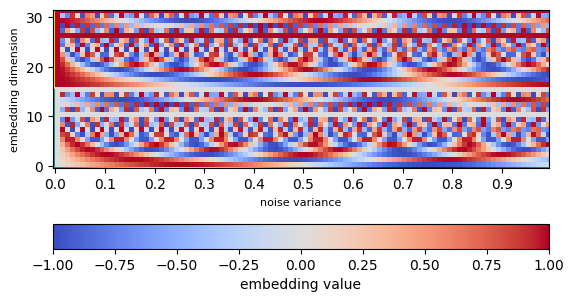

In [30]:
embedding_list = []
for y in np.arange(0, 1, 0.01):
    embedding_list.append(sinusoidal_embedding(np.array([[[[y]]]]))[0][0][0])
print(embedding_list[0], embedding_list[-1])
embedding_array = np.array(np.transpose(embedding_list))
fig, ax = plt.subplots()
ax.set_xticks(
    np.arange(0, 100, 10), labels=np.round(np.arange(0.0, 1.0, 0.1), 1)
)
ax.set_ylabel("embedding dimension", fontsize=8)
ax.set_xlabel("noise variance", fontsize=8)
plt.pcolor(embedding_array, cmap="coolwarm")
plt.colorbar(orientation="horizontal", label="embedding value")
ax.imshow(embedding_array, interpolation="nearest", origin="lower")
plt.show()

In [31]:
def ResidualBlock(width):
    def apply(x):
        input_width = x.shape[3]
        if input_width == width: # Check if the number of channels in the input matches the number of channels we want the block to output.
            # If not, we include another conv layer on the skip connection to bring the number of channels in line with the rest of the block
            residual = x
        else:
            residual = layers.Conv2D(width, kernel_size=1)(x)
        x = layers.BatchNormalization(center=False, scale=False)(x)
        x = layers.Conv2D(
            width, kernel_size=3, padding="same", activation=activations.swish
        )(x)
        x = layers.Conv2D(width, kernel_size=3, padding="same")(x)
        x = layers.Add()([x, residual]) # Recall that a ResidualBlock adds the original input to the output of the conv layers
        return x

    return apply


def DownBlock(width, block_depth):
    def apply(x):
        x, skips = x
        for _ in range(block_depth):
            x = ResidualBlock(width)(x) # Increases the number of channels in the image using a ResidualBlock of a given width, each of which are saved as a skip
            # for the UpBlock
            skips.append(x)
        x = layers.AveragePooling2D(pool_size=2)(x) # Reduces the dimensionality of the image by half
        return x

    return apply

def UpBlock(width, block_depth):
    def apply(x):
        x, skips = x
        x = layers.UpSampling2D(size=2, interpolation="bilinear")(x) # Doubles the size of the image
        for _ in range(block_depth):
            x = layers.Concatenate()([x, skips.pop()]) # Concatenates the x and the skips
            x = ResidualBlock(width)(x) # Reduces the number of channels in the image
        return x

    return apply

In [32]:
# Build the U-Net

noisy_images = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)) # What we are going to denoise
x = layers.Conv2D(32, kernel_size=1)(noisy_images) # Increasing the channels

noise_variances = layers.Input(shape=(1, 1, 1)) # Noise variance, a scalar
noise_embedding = layers.Lambda(sinusoidal_embedding)(noise_variances) # Applies sinusoidal embeddings to the noise variance
noise_embedding = layers.UpSampling2D(size=IMAGE_SIZE, interpolation="nearest")(
    noise_embedding
) # The embedding is copied across spatial dimensions to match the size of the input image

x = layers.Concatenate()([x, noise_embedding]) # Concatenation of the embeddings and noisy images across channels

skips = [] # This will hold the output of the DownBlocks to connect to UpBlocks

x = DownBlock(32, block_depth=2)([x, skips])
x = DownBlock(64, block_depth=2)([x, skips])
x = DownBlock(96, block_depth=2)([x, skips]) # Reducing the spatial size and increasing the channels

x = ResidualBlock(128)(x) # These hold the image size and number of channels constant
x = ResidualBlock(128)(x)

x = UpBlock(96, block_depth=2)([x, skips]) # We concatenate the x and the skips and rebuild the images spatially while reducing the channels
x = UpBlock(64, block_depth=2)([x, skips])
x = UpBlock(32, block_depth=2)([x, skips])

x = layers.Conv2D(3, kernel_size=1, kernel_initializer="zeros")(x) # Reduces the channels to 3, and we already have the same spatial size

unet = models.Model([noisy_images, noise_variances], x, name="unet") # The model takes the noisy images, the noise variance, and outputs the noise itself

In [33]:
class DiffusionModel(models.Model):
    def __init__(self):
        super().__init__()

        self.normalizer = layers.Normalization()
        self.network = unet
        self.ema_network = models.clone_model(self.network) # The EMA is an exponential moving average of past timesteps' weights and is less susceptible to large changes/spikes
        self.diffusion_schedule = offset_cosine_diffusion_schedule

    def compile(self, **kwargs):
        super().compile(**kwargs)
        self.noise_loss_tracker = metrics.Mean(name="n_loss")

    @property
    def metrics(self):
        return [self.noise_loss_tracker]

    def denormalize(self, images):
        images = self.normalizer.mean + images * self.normalizer.variance**0.5
        return tf.clip_by_value(images, 0.0, 1.0)

    def denoise(self, noisy_images, noise_rates, signal_rates, training):
        if training:
            network = self.network
        else:
            network = self.ema_network
        pred_noises = network(
            [noisy_images, noise_rates**2], training=training
        ) # We give the model the noisy images and the noise_rates squared (because if you look at the original noisy image creation,
        # we have the square root of 1-alpha_bar and it is acting like the standard deviation and we want the variance)
        pred_images = (noisy_images - noise_rates * pred_noises) / signal_rates

        return pred_noises, pred_images

    def reverse_diffusion(self, initial_noise, diffusion_steps):
        num_images = initial_noise.shape[0]
        step_size = 1.0 / diffusion_steps # Size of the change in t
        current_images = initial_noise # Begin with images of just noise
        for step in range(diffusion_steps): # Steppung through our number of steps
            diffusion_times = tf.ones((num_images, 1, 1, 1)) - step * step_size # The step begins at 0, so our diffusion times are set to 1 in the beginning, 
            # which makes sense, as we are starting with the most diffuse and working back to t=0.
            noise_rates, signal_rates = self.diffusion_schedule(diffusion_times) # Getting our rates at that diffusion time t
            pred_noises, pred_images = self.denoise(
                current_images, noise_rates, signal_rates, training=False
            ) # Getting the denoised images and predicted noise from our model at time t=0. As in, this is attempting to completely denoise, going from time t to t=0
            next_diffusion_times = diffusion_times - step_size # Reducing the diffusion times at the next step
            next_noise_rates, next_signal_rates = self.diffusion_schedule(
                next_diffusion_times
            ) # Another step of the model, rates for t-1
            current_images = (
                next_signal_rates * pred_images + next_noise_rates * pred_noises
            ) # Current images are calculated with the provided equation (note we have no sigma, as this is deterministic at this step)
            # Note that we are applying the predicted rates for t-1. So, we predicted x_0 (pred images) from time t and we are then renoising it up to t-1.
            # The idea being that we can slowly reduce the noise to arrive at our original once we arrive at t=1 from t=T.
        return pred_images

    def generate(self, num_images, diffusion_steps, initial_noise=None):
        if initial_noise is None:
            initial_noise = tf.random.normal(
                shape=(num_images, IMAGE_SIZE, IMAGE_SIZE, 3)
            ) # Starting off with random noise
        generated_images = self.reverse_diffusion(
            initial_noise, diffusion_steps
        ) # Generating images
        generated_images = self.denormalize(generated_images) # Denormalizing them
        return generated_images

    def train_step(self, images):
        images = self.normalizer(images, training=True) # Normalize the images first
        noises = tf.random.normal(shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, 3)) # Sample from a normal of size (Batch, H, W, 3) as the noise

        diffusion_times = tf.random.uniform(
            shape=(BATCH_SIZE, 1, 1, 1), minval=0.0, maxval=1.0
        ) # Batch of times, giving us (Batch, t), where t is pulled from U[0,1]
        noise_rates, signal_rates = self.diffusion_schedule(diffusion_times) # Getting the alpha_bar rates

        noisy_images = signal_rates * images + noise_rates * noises # Creating our noisy images. This is the same as the equation above

        with tf.GradientTape() as tape:
            # train the network to separate noisy images to their components
            pred_noises, pred_images = self.denoise(
                noisy_images, noise_rates, signal_rates, training=True
            ) # Getting the predicted noise

            noise_loss = self.loss(noises, pred_noises)  # Loss calculation

        gradients = tape.gradient(noise_loss, self.network.trainable_weights)
        self.optimizer.apply_gradients(
            zip(gradients, self.network.trainable_weights)
        )

        self.noise_loss_tracker.update_state(noise_loss)

        for weight, ema_weight in zip(
            self.network.weights, self.ema_network.weights
        ):
            ema_weight.assign(EMA * ema_weight + (1 - EMA) * weight) # EMA weights are a weighted average of the existing EMA weights and the trained network weights after the gradient step

        return {m.name: m.result() for m in self.metrics}

    def test_step(self, images):
        images = self.normalizer(images, training=False)
        noises = tf.random.normal(shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, 3))
        diffusion_times = tf.random.uniform(
            shape=(BATCH_SIZE, 1, 1, 1), minval=0.0, maxval=1.0
        )
        noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)
        noisy_images = signal_rates * images + noise_rates * noises
        pred_noises, pred_images = self.denoise(
            noisy_images, noise_rates, signal_rates, training=False
        )
        noise_loss = self.loss(noises, pred_noises)
        self.noise_loss_tracker.update_state(noise_loss)

        return {m.name: m.result() for m in self.metrics}

In [34]:
ddm = DiffusionModel()
ddm.normalizer.adapt(train)

2023-08-07 16:26:18.326755: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [8189]
	 [[{{node Placeholder/_0}}]]
2023-08-07 16:26:18.326951: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [8189]
	 [[{{node Placeholder/_0}}]]


In [35]:
if LOAD_MODEL:
    ddm.built = True
    ddm.load_weights("./checkpoint/checkpoint.ckpt")

## 3.Train the model <a name="train"></a>

In [36]:
ddm.compile(
    optimizer=optimizers.experimental.AdamW(
        learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    ),
    loss=losses.mean_absolute_error,
)

Epoch 1/50


639/639 [==============================] - ETA: 0s - n_loss: 0.2317
Saved to /home/clachris/Documents/projects/Generative_Deep_Learning_2nd_Edition/notebooks/08_diffusion/01_ddm/output/generated_img_000.png


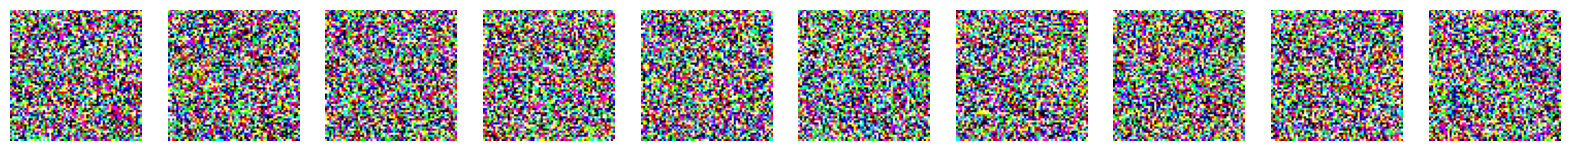

639/639 [==============================] - 1526s 2s/step - n_loss: 0.2317
Epoch 2/50
639/639 [==============================] - 1536s 2s/step - n_loss: 0.1958
Epoch 3/50
639/639 [==============================] - 1536s 2s/step - n_loss: 0.1894
Epoch 4/50
639/639 [==============================] - 1532s 2s/step - n_loss: 0.1853
Epoch 5/50
639/639 [==============================] - 1517s 2s/step - n_loss: 0.1830
Epoch 6/50
639/639 [==============================] - ETA: 0s - n_loss: 0.1815
Saved to /home/clachris/Documents/projects/Generative_Deep_Learning_2nd_Edition/notebooks/08_diffusion/01_ddm/output/generated_img_005.png


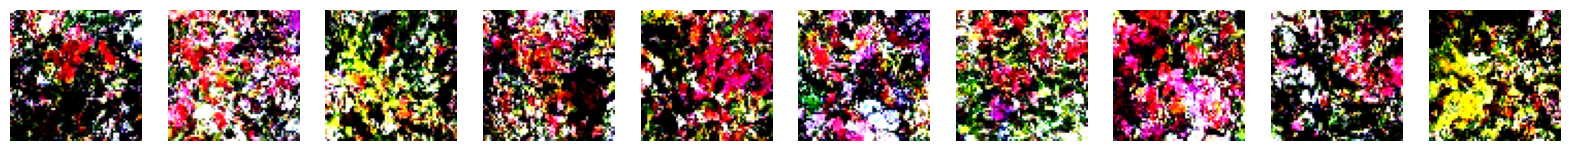

639/639 [==============================] - 1549s 2s/step - n_loss: 0.1815
Epoch 7/50
639/639 [==============================] - 1520s 2s/step - n_loss: 0.1814
Epoch 8/50
639/639 [==============================] - 1498s 2s/step - n_loss: 0.1796
Epoch 9/50
639/639 [==============================] - 1511s 2s/step - n_loss: 0.1796
Epoch 10/50
639/639 [==============================] - 1511s 2s/step - n_loss: 0.1787
Epoch 11/50
639/639 [==============================] - ETA: 0s - n_loss: 0.1777
Saved to /home/clachris/Documents/projects/Generative_Deep_Learning_2nd_Edition/notebooks/08_diffusion/01_ddm/output/generated_img_010.png


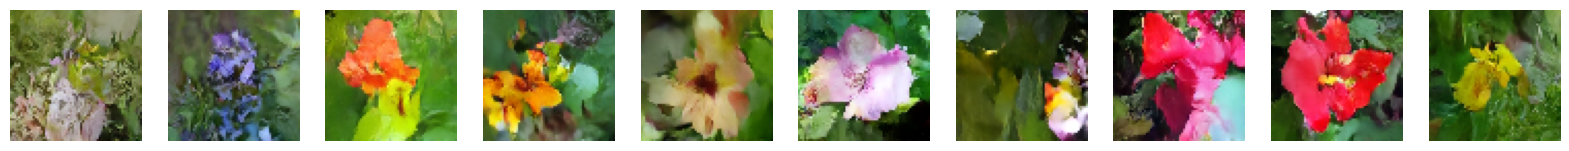

639/639 [==============================] - 1510s 2s/step - n_loss: 0.1777
Epoch 12/50
639/639 [==============================] - 1493s 2s/step - n_loss: 0.1778
Epoch 13/50
639/639 [==============================] - 1501s 2s/step - n_loss: 0.1769
Epoch 14/50
639/639 [==============================] - 1497s 2s/step - n_loss: 0.1760
Epoch 15/50
639/639 [==============================] - 1494s 2s/step - n_loss: 0.1770
Epoch 16/50
639/639 [==============================] - ETA: 0s - n_loss: 0.1753
Saved to /home/clachris/Documents/projects/Generative_Deep_Learning_2nd_Edition/notebooks/08_diffusion/01_ddm/output/generated_img_015.png


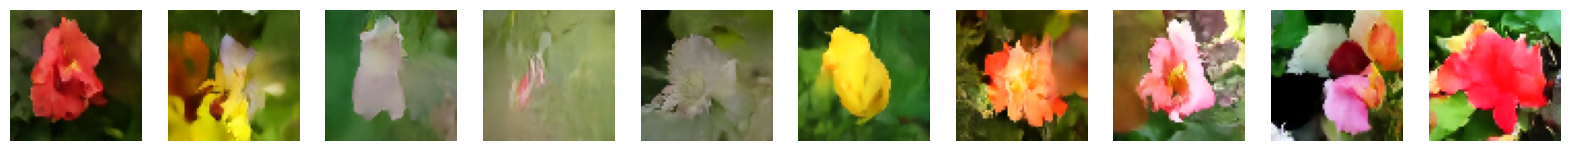

639/639 [==============================] - 1501s 2s/step - n_loss: 0.1753
Epoch 17/50
639/639 [==============================] - 1499s 2s/step - n_loss: 0.1754
Epoch 18/50
639/639 [==============================] - 1501s 2s/step - n_loss: 0.1752
Epoch 19/50
639/639 [==============================] - 1499s 2s/step - n_loss: 0.1745
Epoch 20/50
639/639 [==============================] - 1500s 2s/step - n_loss: 0.1749
Epoch 21/50
639/639 [==============================] - ETA: 0s - n_loss: 0.1746
Saved to /home/clachris/Documents/projects/Generative_Deep_Learning_2nd_Edition/notebooks/08_diffusion/01_ddm/output/generated_img_020.png


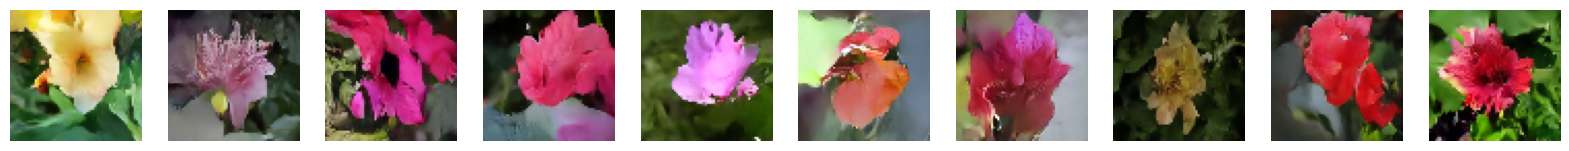

639/639 [==============================] - 1501s 2s/step - n_loss: 0.1746
Epoch 22/50
639/639 [==============================] - 1489s 2s/step - n_loss: 0.1740
Epoch 23/50
639/639 [==============================] - 1496s 2s/step - n_loss: 0.1747
Epoch 24/50
639/639 [==============================] - 1499s 2s/step - n_loss: 0.1737
Epoch 25/50
639/639 [==============================] - 1502s 2s/step - n_loss: 0.1741
Epoch 26/50
639/639 [==============================] - ETA: 0s - n_loss: 0.1733
Saved to /home/clachris/Documents/projects/Generative_Deep_Learning_2nd_Edition/notebooks/08_diffusion/01_ddm/output/generated_img_025.png


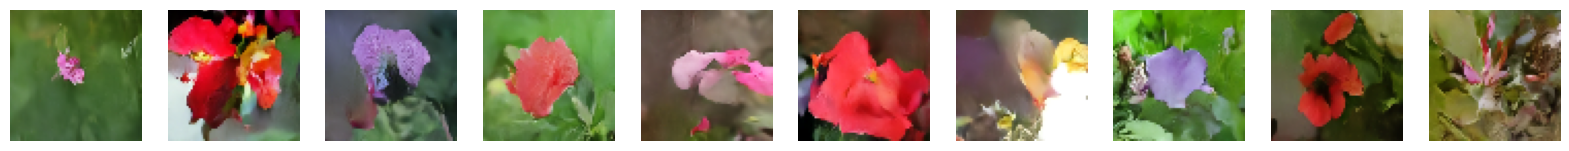

639/639 [==============================] - 1501s 2s/step - n_loss: 0.1733
Epoch 27/50
639/639 [==============================] - 1511s 2s/step - n_loss: 0.1733
Epoch 28/50
639/639 [==============================] - 1510s 2s/step - n_loss: 0.1728
Epoch 29/50
639/639 [==============================] - 1506s 2s/step - n_loss: 0.1736
Epoch 30/50
639/639 [==============================] - 1506s 2s/step - n_loss: 0.1735
Epoch 31/50
639/639 [==============================] - ETA: 0s - n_loss: 0.1732
Saved to /home/clachris/Documents/projects/Generative_Deep_Learning_2nd_Edition/notebooks/08_diffusion/01_ddm/output/generated_img_030.png


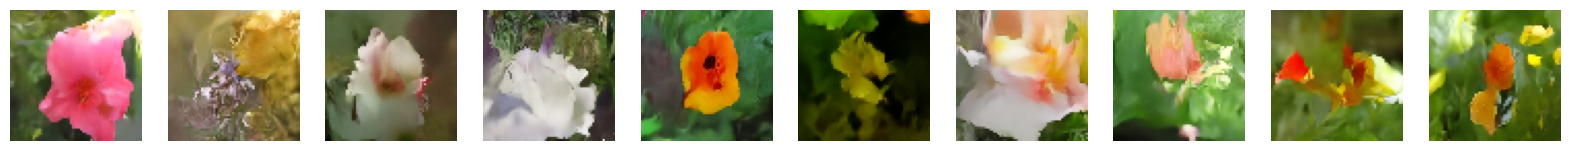

639/639 [==============================] - 1507s 2s/step - n_loss: 0.1732
Epoch 32/50
639/639 [==============================] - 1502s 2s/step - n_loss: 0.1733
Epoch 33/50
639/639 [==============================] - 1499s 2s/step - n_loss: 0.1726
Epoch 34/50
639/639 [==============================] - 1529s 2s/step - n_loss: 0.1724
Epoch 35/50
639/639 [==============================] - 1536s 2s/step - n_loss: 0.1724
Epoch 36/50
639/639 [==============================] - ETA: 0s - n_loss: 0.1726
Saved to /home/clachris/Documents/projects/Generative_Deep_Learning_2nd_Edition/notebooks/08_diffusion/01_ddm/output/generated_img_035.png


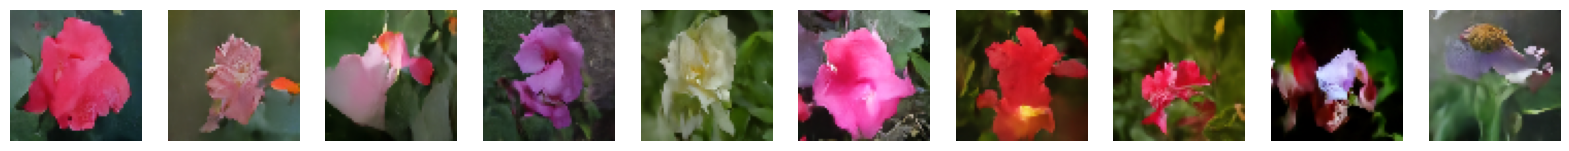

639/639 [==============================] - 1531s 2s/step - n_loss: 0.1726
Epoch 37/50
639/639 [==============================] - 1532s 2s/step - n_loss: 0.1727
Epoch 38/50
639/639 [==============================] - 1527s 2s/step - n_loss: 0.1724
Epoch 39/50
639/639 [==============================] - 1523s 2s/step - n_loss: 0.1715
Epoch 40/50
639/639 [==============================] - 4932s 8s/step - n_loss: 0.1724
Epoch 41/50
639/639 [==============================] - ETA: 0s - n_loss: 0.1724
Saved to /home/clachris/Documents/projects/Generative_Deep_Learning_2nd_Edition/notebooks/08_diffusion/01_ddm/output/generated_img_040.png


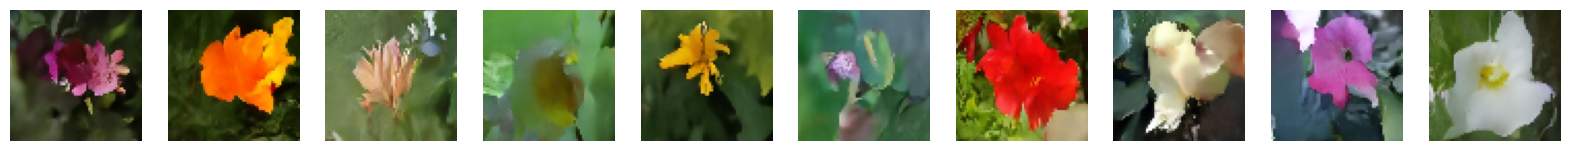

639/639 [==============================] - 1537s 2s/step - n_loss: 0.1724
Epoch 42/50
639/639 [==============================] - 1576s 2s/step - n_loss: 0.1715
Epoch 43/50
639/639 [==============================] - 1529s 2s/step - n_loss: 0.1718
Epoch 44/50
639/639 [==============================] - 1514s 2s/step - n_loss: 0.1716
Epoch 45/50
639/639 [==============================] - 1499s 2s/step - n_loss: 0.1719
Epoch 46/50
639/639 [==============================] - ETA: 0s - n_loss: 0.1719
Saved to /home/clachris/Documents/projects/Generative_Deep_Learning_2nd_Edition/notebooks/08_diffusion/01_ddm/output/generated_img_045.png


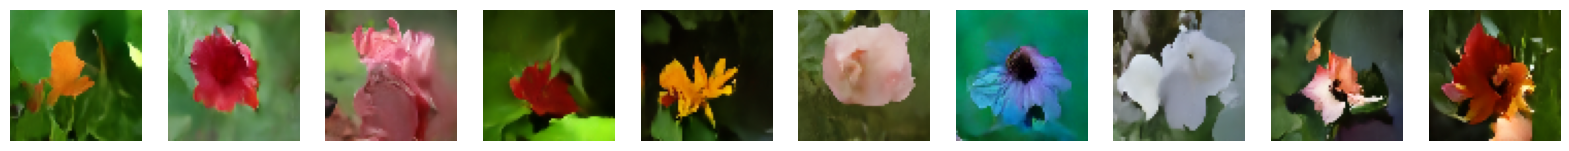

639/639 [==============================] - 1502s 2s/step - n_loss: 0.1719
Epoch 47/50
639/639 [==============================] - 1502s 2s/step - n_loss: 0.1720
Epoch 48/50
639/639 [==============================] - 1523s 2s/step - n_loss: 0.1712
Epoch 49/50
639/639 [==============================] - 1501s 2s/step - n_loss: 0.1715
Epoch 50/50
639/639 [==============================] - 1496s 2s/step - n_loss: 0.1720


In [38]:
# run training and plot generated images periodically
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint/checkpoint.ckpt",
    save_weights_only=True,
    save_freq="epoch",
    verbose=0,
)

tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")


class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img):
        self.num_img = num_img

    def on_epoch_end(self, epoch, logs=None):
        if epoch % 5 == 0: # Saving/displaying every 5th epoch
            generated_images = self.model.generate(
                num_images=self.num_img,
                diffusion_steps=PLOT_DIFFUSION_STEPS,
            ).numpy()
            display(
                generated_images,
                save_to="/home/clachris/Documents/projects/Generative_Deep_Learning_2nd_Edition/notebooks/08_diffusion/01_ddm/output/generated_img_%03d.png" % (epoch),
            )


image_generator_callback = ImageGenerator(num_img=10)

ddm.fit(
    train,
    epochs=EPOCHS,
    callbacks=[
        model_checkpoint_callback,
        tensorboard_callback,
        image_generator_callback,
    ],
)

## 4. Inference <a name="inference"></a>

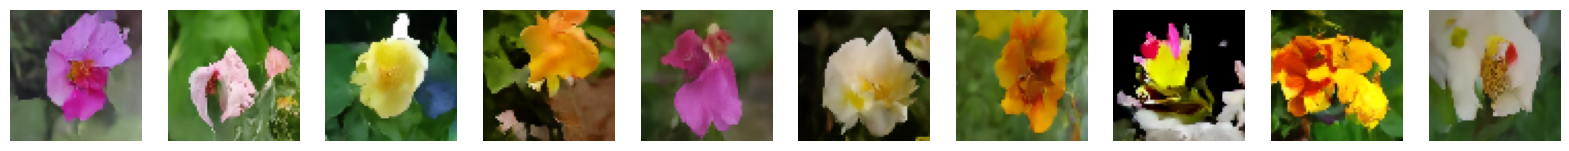

In [39]:
# Generate some novel images of flowers
generated_images = ddm.generate(num_images=10, diffusion_steps=20).numpy()
display(generated_images)

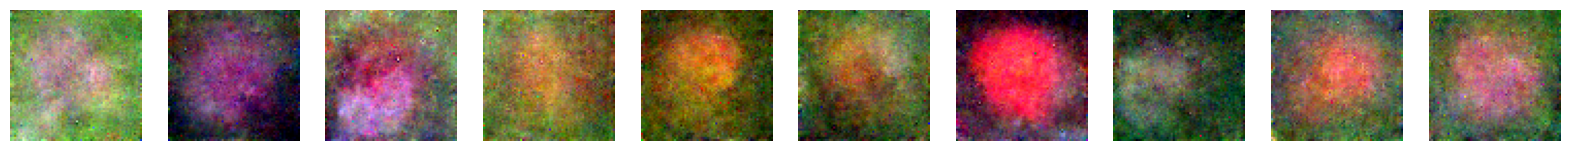

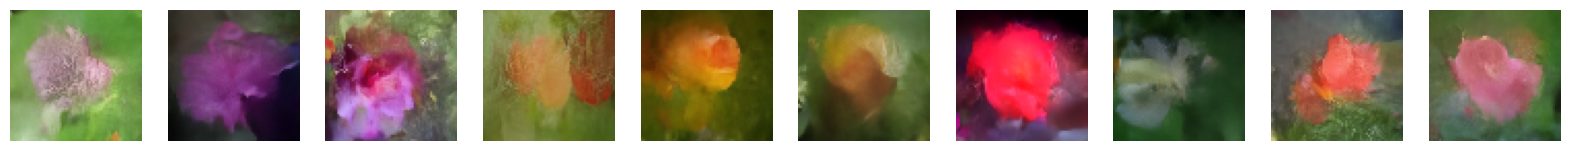

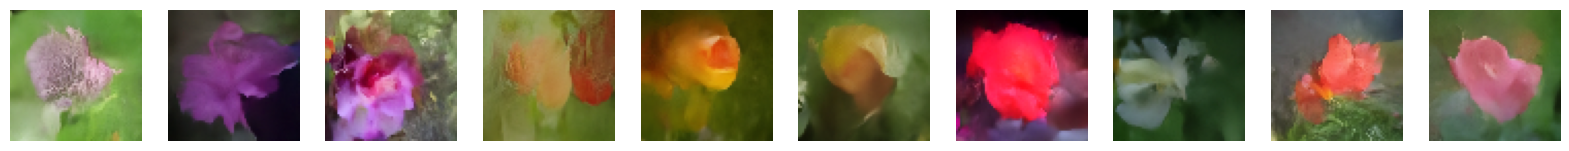

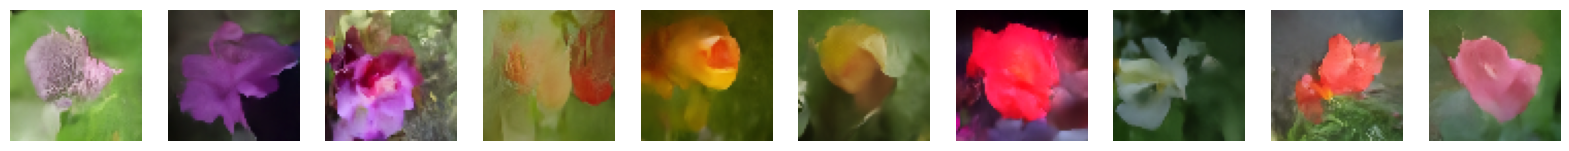

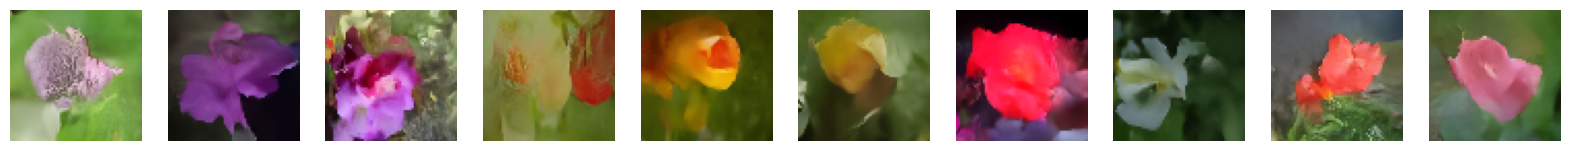

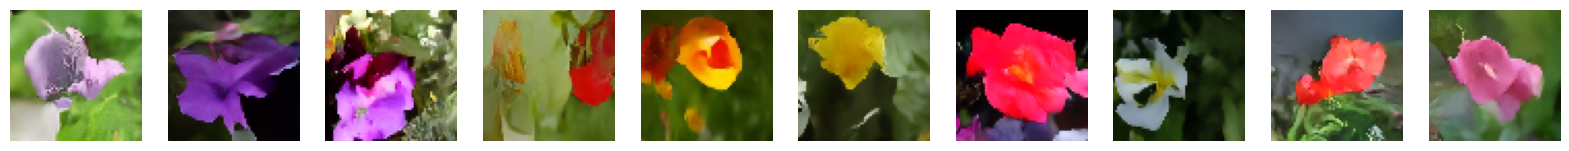

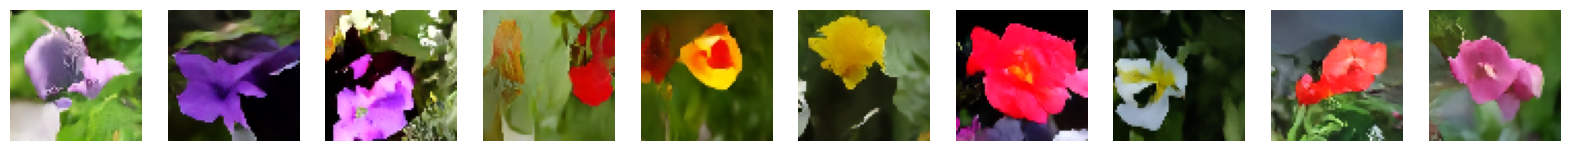

In [40]:
# View improvement over greater number of diffusion steps
for diffusion_steps in list(np.arange(1, 6, 1)) + [20] + [100]:
    tf.random.set_seed(42)
    generated_images = ddm.generate(
        num_images=10,
        diffusion_steps=diffusion_steps,
    ).numpy()
    display(generated_images)

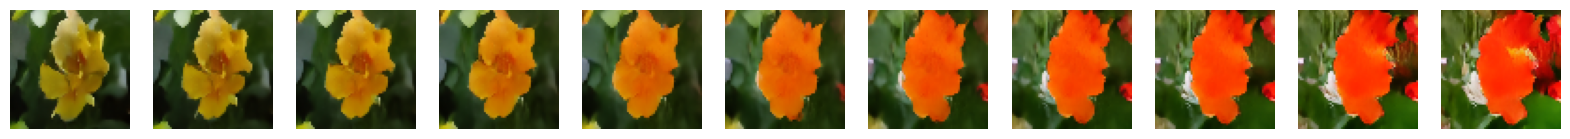

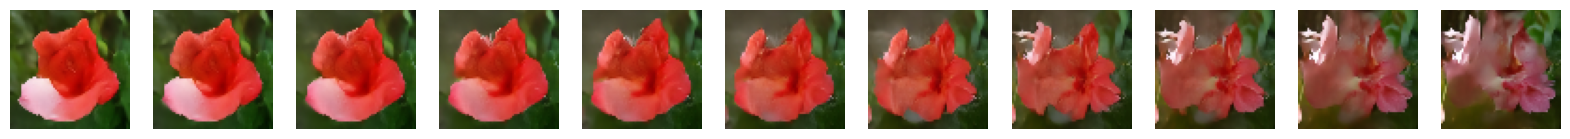

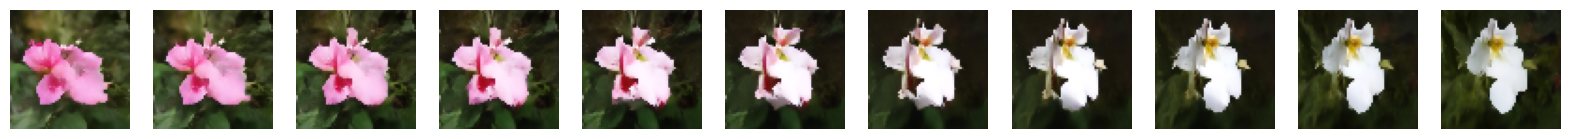

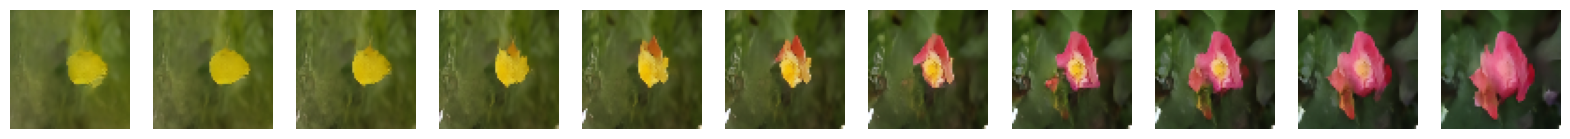

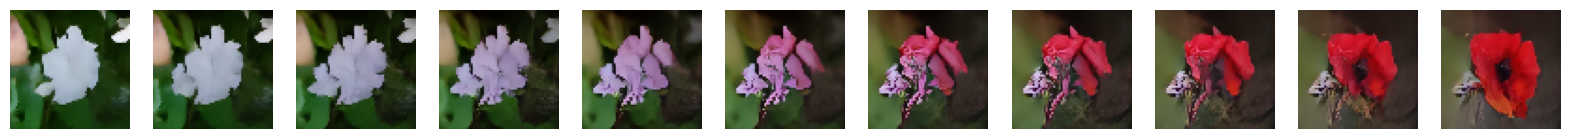

In [41]:
# Interpolation between two points in the latent space
tf.random.set_seed(100)


def spherical_interpolation(a, b, t):
    return np.sin(t * math.pi / 2) * a + np.cos(t * math.pi / 2) * b


for i in range(5):
    a = tf.random.normal(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    b = tf.random.normal(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    initial_noise = np.array(
        [spherical_interpolation(a, b, t) for t in np.arange(0, 1.1, 0.1)]
    )
    generated_images = ddm.generate(
        num_images=2, diffusion_steps=20, initial_noise=initial_noise
    ).numpy()
    display(generated_images, n=11)